In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

%matplotlib inline

In [2]:
"""Constants"""
eps0 = 8.854e-12 #[F/m]
e = 1.60217662e-19 #elementary charge [C]
h = 6.62607004e-34 #Planck's constant [Js]
m_e = 9.10938356e-31 #electron mass [kg]

In [3]:
"""Material dependant constants:"""
'''Fluid'''
fluid_density = 0.164 #helium
eta = 3.12e-5 #shear viscosity = kinematic viscosity * denisty of fluid
beta = 0 #bulk viscoisty
kinematic_viscosity = 3.12e-5/fluid_density
eps_rel = 1 #relative permittivity
eps = eps0 * eps_rel
k = 1/(4*math.pi*eps)

'''QDs'''
#(InAs/GaAs QDs)
Rt = (10*h)/(e**2) #tunneling resistance (made up value)
m_eeff = 0.067 * m_e #electron effective mass [kg]
m_heff = 0.34 * m_e #hole effective mass [kg]
E_g = 0.36 * 1.60217662e-19 #band gap of QD (InAs bulk) [J]


'''Inner section'''
cap_d = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
rho = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]
R_c = 1 #capacitor circuit resistance

In [4]:
"""Initial parameter functions"""
def seperation_angle(n):
    return ( (2*math.pi)/n )

def setup_radius(sep, diam, PHI):
    return ( (sep + diam)/(2 * math.sin(PHI/2)) )

def cog_length( Rp, PHI):
    r = ( Rp*math.sin(PHI) )/(4*math.sin(PHI/2))
    return r

def width( Rp, PHI):
    w = ( Rp*math.sin(PHI) )/2
    return w

def intertia( rho, thc, Rp):
    """Calculates inertia of inner rotating disk"""
    I = 0.5 * rho * math.pi * thc * ( Rp ** 4 ) #for disc, needs to be changed for cog shape
    return I

In [5]:
"""Motor setup functions"""

def permanent_charge_magnitude( r, width, cap_d, cap_vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = (r/2) * width
    capacitance = cap_d * segment_area #capacitance of one segment
    stored_charge = capacitance * cap_vol #stored charge in one segment
    return stored_charge

def permanent_charges( Rp, p , cap_d, cap_vol, width, r):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( r, width, cap_d, cap_vol)
        else:
            p_ch = -permanent_charge_magnitude( r, width, cap_d, cap_vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

def quantum_dots( n, e, noc):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, n, 4): #will result in +ve torque ==> turning anti-clockwise
            q_ch = noc*e
        elif i in range(3, n, 4):
            q_ch = -noc*e
        else:
            q_ch = 0
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [6]:
"""Active motor functions"""

def tangential_component(k , n, e, R, Rp, gamma, noc, width, r):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n, e, noc) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(2*R*(R-r0)*(1-math.cos(QDs[i][2]-gamma))+r0**2) #distance between QD and permanent charge edge
        ric = math.sqrt(  ( (Rp-(r/4) )**2) + (R**2) - 2*(Rp-(r/4))*R*math.cos(QDs[i][2]-gamma) ) #distance between QD and permanent charge center
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        '''Alpha is alpha at edge of permanent charge'''
        if ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) > 1 or ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha        
        '''Alphac is alpha at center of permanent charge'''
        if ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) > 1 or ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) < -1 : #accounts for computational error
            alphac = 0
        else:
            alphac = math.acos((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) #angle to tangential in which force vector acts
        if i > n/2:
            alphac = -alphac
        ex_minus = ri*math.sin(alpha) - (width/2)
        ex_plus = ri*math.sin(alpha) + (width/2)
        ey_minus = ri*math.cos(alpha)
        ey_plus = ri*math.cos(alpha) + (r/2)
        sigma = PCs[0][3]/(width*r)
        f = force(ex_minus, ex_plus, ey_minus, ey_plus)
        F_c = k*sigma*Q[3]*f #coulomb force between permanent charge and QD
        F_t += F_c*math.sin(alphac)
    return F_t

def force( c1, c2, c3, c4):
    a1 = (c4 + math.sqrt((c4**2)+(c1**2)))*(c3 + math.sqrt((c3**2)+(c2**2)))
    b1 = (c4 + math.sqrt((c4**2)+(c2**2)))*(c3 + math.sqrt((c3**2)+(c1**2)))
    a2 = (c2 + math.sqrt((c2**2)+(c3**2)))*(c1 + math.sqrt((c1**2)+(c4**2)))
    b2 = (c2 + math.sqrt((c2**2)+(c4**2)))*(c1 + math.sqrt((c1**2)+(c3**2)))
    I1 = math.log(a1/b1)
    I2 = math.log(a2/b2)
    f = math.sqrt( (I1**2) + (I2**2) )
    return f

def torque (F_t, Rp, p, r):
    """Computes torque on enitre inner rotor"""
    torque_radius = Rp - r/4
    torque = F_t * torque_radius * p
    return torque

def angular_velocity(angle_increment, v_ang, i, torque, inertia):
    """Calculates the angular velocity after rotating the angle increment"""
    w_f = 0
    w_f = math.sqrt( (v_ang[i])**2 + (2*torque*angle_increment)/inertia )
    return w_f

def time_step(inertia, torque, v_ang):
    """Calculates time taken to reach new v_ang"""
    tau = (v_ang[i] - v_ang[i-1])* inertia/torque
    return tau

def Charging_voltage_QD( n, e, Cdot):
    """Constant voltage required to maintain QD charge"""
    QDs = quantum_dots(n,e, noc) #calls function to initialize QDs
    voltage = ( QDs[0][3]/(2*Cdot) ) #voltage needed to add one electron
    return voltage

def QD_capacitance( eps, d):
    Cdot = 2*math.pi*eps*d
    return Cdot

def Charging_time( R, C):
    "Computes charging time for dot and capacitor"
    tc = 4 * R * C
    return tc

def Input_energy (n, e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c):
    """Input power for each step"""
    #for capacitor charging
    E_cC = (PCs[0][3] * cap_vol)
    #for -ve charged dots, energy corresponds to that needed to the required voltage to cause electrons to tunnel into the dot
    E_cQD = (Charging_voltage_QD( n, e, Cdot) * noc * e )
    #for +ve charged dots, energy corresponds to laser energy plus voltage emergy to make electrons tunnel out of the dot
    #laser energy depends on bandgap/energy level seperation
    if (noc % 2 == 0):
        J = noc/2
    else:
        J = (noc + 1)/2
    
    E_l = E_g + ((h**2)*J/(8*m_eeff*(diam**2))) + ((h**2)*J/(8*m_heff*(diam**2)))
    #print( E_cQD )
    #print( E_cC )
    E_intotal = (E_cQD * n) + ( (n/2) * (E_l + E_cC) )
    return E_intotal

def Output_power(angv, torque):
    return angv * torque

def Output_energy(angv, I):
    E_out = 0.5 * I * (angv**2)
    return E_out

def efficiency(E_in, E_out):
    eff = (E_out/E_in)
    return eff

In [7]:
"""Mathematical functions"""

def func(x, A, B, C, D, E, F, G, H, J, K, L):
    return A * (x**10) + B * (x**9) + C * (x**8)+ D * (x**7) + E * (x**6) + F * (x**5) + G * (x**4) + H * (x**3) + J * (x**2) + K * x + L 

def solvr( Y, t, params):
    const, A, B, C, D, E, F, G, H, J, K, L = params
    return [ Y[1], ( A * (Y[0]**10) + B * (Y[0]**9) + C * (Y[0]**8)+ D * (Y[0]**7) + E * (Y[0]**6) + F * (Y[0]**5) + G * (Y[0]**4) + H * (Y[0]**3) + J * (Y[0]**2) + K * Y[0] + L - const * Y[1]) ]

In [8]:
"""Initial parameters:"""
'''QDs'''
diam = 10e-9 #diameter of QDs [m]
sep = 130e-9 #seperation of QDs [m] (corresponds to motor dead zone)
n = 80   #number of QDs [no unit]
PHI = seperation_angle(n) #angle of seperation between QDs
R = setup_radius(sep, diam, PHI)  #radius of QD setup [m] 5.36290830288e-07
noc = 6 #number of charge carriers contributing to net charge of QD
'''Inner section'''
p = int(n/2)   #number of permanent charges (PCs) [no unit]
r0 = 110e-9
Rp = R - r0   #radius of rotating disc [m]
w = width( Rp, PHI )#cog "tooth"/capacitor arm width [m]
r = cog_length( Rp, PHI)    #length of the cog shaft [m]
thc = 30e-9   #approximate thickeness of inner disc [m]
cap_vol = 2   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
I = intertia( rho, thc, Rp) #inertia of inner rotating disk

'''Medium'''
constant =  p * 1.08037675928e-11  #coefficient of drag force function

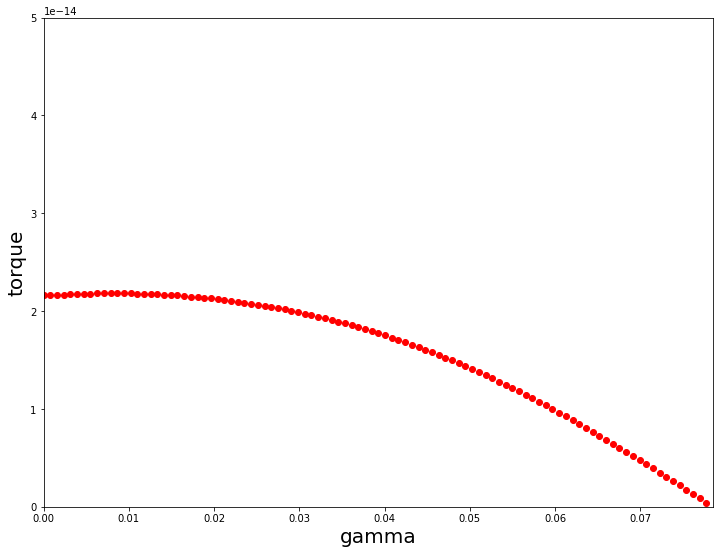

In [11]:
"""Main function"""
time = 0
step = math.pi*(360/n)/180 #angle between each QD, angle required for one step
angle_increment = step/100
PCs = permanent_charges( Rp, p , cap_d, cap_vol, w, r) #initializes permanent charges

"""Graph of torque function to be approximated"""
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('gamma', fontsize = '20')
ax1.set_ylabel('torque', fontsize = '20')
ax1.set_xlim( 0 , step )
ax1.set_ylim( 0 , 5e-14)

"""Computation of 'true' torque """
i = 0
T = []
gamma_list = []
for gamma in np.arange(0, step, angle_increment): #iterates angle increment until one step is completed
    gamma_list.append( gamma )
    F_t = tangential_component(k , n, e, R, Rp, gamma, noc, w, r)
    T.append( torque(F_t, Rp, p, r) ) #calculates torque acting on inner rotor
    ax1.scatter(gamma, T[i] , color = 'r') #plots torque vs angle rotated
    i += 1 #needed to keep track of T array

plt.show()

C:\Users\Pauli\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


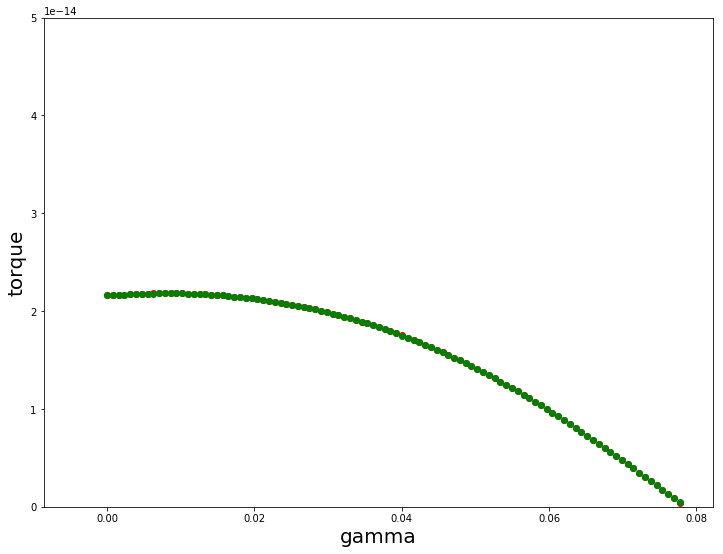

In [12]:
"""Approximate torque function"""
popt, pcov = curve_fit(func, gamma_list, T)

A = popt[0]
B = popt[1]
C = popt[2]
D = popt[3]
E = popt[4]
F = popt[5]
G = popt[6]
H = popt[7]
J = popt[8]
K = popt[9]
L = popt[10]

fig2 = plt.figure(figsize=(12, 9))
bx1 = fig2.add_subplot(111)
bx2 = fig2.add_subplot(111)
bx1.set_xlabel('gamma', fontsize = '20')
bx1.set_ylabel('torque', fontsize = '20')
bx1.set_ylim( 0 , 5e-14)
for i in np.arange( 0, int(step/angle_increment) ):
    bx1.scatter( gamma_list[i], T[i], color = 'r' )
    bx2.scatter( gamma_list[i], ( func(gamma_list[i], A, B, C, D, E, F, G, H, J, K, L) ), color= 'g' )
plt.show()

In [13]:
"""Solve ODE for motor with viscous drag"""
params = [ (constant*((Rp-(r/4))/2))/I , A/I, B/I, C/I, D/I, E/I, F/I, G/I, H/I, J/I, K/I, L/I ]
tStop = 1
tInc = 1e-5
t_array = np.arange( 0, tStop, tInc)
sol = odeint( solvr, [0,0], t_array, args=(params,) )

In [14]:
keep_i = 0
for i in np.arange( 0, len(t_array) ):
    if sol[i][0] >= step:
        keep_i = i
        break
    else:
        keep_i = len(t_array)

print (step)
print (len(t_array))
print (keep_i)
snipped_sol = np.zeros((keep_i, 2))
snipped_sol = sol[:keep_i]
#print (snipped_sol)

0.07853981633974483
100000
515


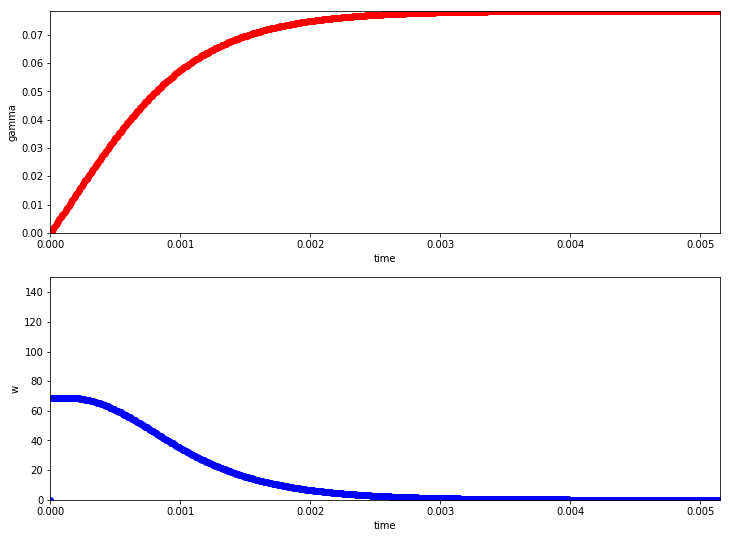

In [15]:
"""Plot solution"""
fig3 = plt.figure(figsize=(12, 9))
cx1 = fig3.add_subplot(211)
cx1.set_xlabel('time')
cx1.set_ylabel('gamma')
cx1.set_ylim( 0 , step )
cx1.set_xlim( 0 , t_array[keep_i] )
cx2 = fig3.add_subplot(212)
cx2.set_xlabel('time')
cx2.set_ylabel('w')
cx2.set_ylim( 0 , 150 )
cx2.set_xlim( 0 , t_array[keep_i] )
for i in np.arange( 0, len(snipped_sol) ):
    cx1.scatter( t_array[i], snipped_sol[i][0], color='r' )
    cx2.scatter( t_array[i], snipped_sol[i][1], color='b' )
plt.show()

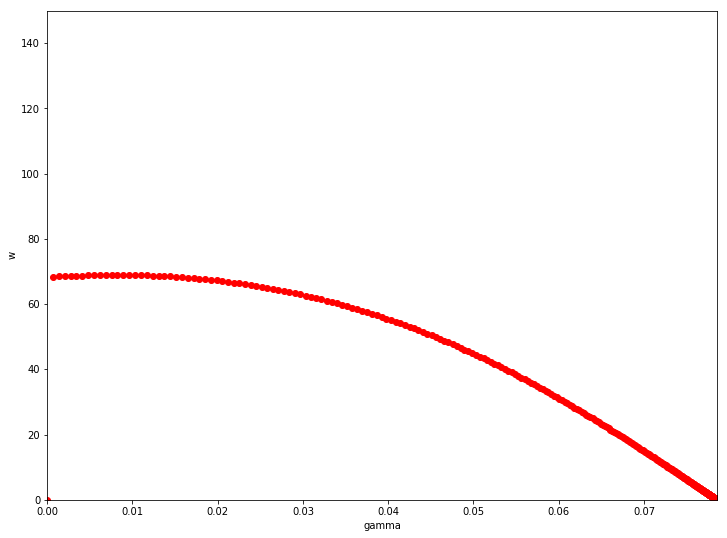

In [16]:
fig4 = plt.figure(figsize=(12, 9))
dx1 = fig4.add_subplot(111)
dx1.set_xlabel('gamma')
dx1.set_ylabel('w')
dx1.set_ylim( 0 , 150 )
dx1.set_xlim( 0 , PHI)

for i in np.arange( 0, len(snipped_sol) ):
    dx1.scatter( snipped_sol[i][0], snipped_sol[i][1], color='r' )
    
plt.show()

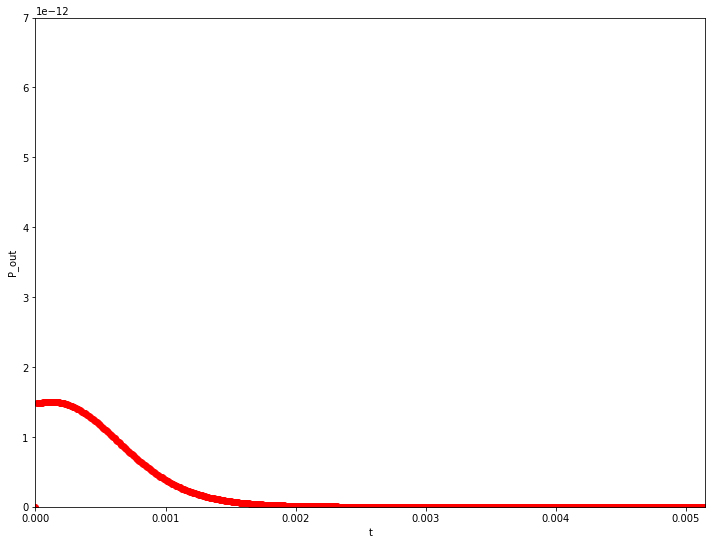

In [17]:
fig5 = plt.figure(figsize=(12, 9))
ex1 = fig5.add_subplot(111)
ex1.set_xlabel('t')
ex1.set_ylabel('P_out')
ex1.set_ylim( 0 , 7e-12 )
ex1.set_xlim( 0 , t_array[keep_i] )
p_out_list = []
p_out = 0
for i in np.arange( 0, len(snipped_sol) ):
    p_out = Output_power(snipped_sol[i][1], func(snipped_sol[i][0], A, B, C, D, E, F, G, H, J, K, L) )
    #print (p_out)
    ex1.scatter( t_array[i], p_out, color='r' )
    p_out_list.append(p_out)
    
plt.show()


In [18]:
E_OUT = 0
for i in np.arange( 0, len(snipped_sol) ):
    E_OUT += p_out_list[i] * tInc

print (E_OUT)

1.1941503789e-15


In [19]:
"""Computes input power for each step"""
Cdot = QD_capacitance( eps, diam)
E_in = Input_energy (n, e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c)
print (E_in) #total input energy

1.7291155697617676e-12


In [20]:
"""Efficiency"""
eff = efficiency(E_in, E_OUT)
print (eff*100)

0.0690613397844
